[![Colab Badge](http://img.shields.io/badge/Colaboratory-black?style=for-the-badge&logo=google-colab)](https://colab.research.google.com/github/TINYML-KOR/assignment/blob/main/Lab3_oohyun.ipynb)

# **Lab 3: Neural Architecture Search(NAS)**
> MIT 6.5940 EfficientML.ai Fall 2023

이번 시간은 Neural Architecture Search(NAS)에서 실습을 해보는 시간이였어요. 파라미터를 가지고 네트워크를 더 깊게 만들거나, 채널을 더 크게 만드는 방법에 대해 실제로  코드 예시가 친절하게 돼 있어, 실험결과를 자세히 보기 좋았던 예제입니다. 영어로 된 설명은 NAS 강의에 나오는 자료라 꼭 읽으실 필요는 없어요. 그리고 중간중간에 이해를 돕기 위한 다이어그램이나 설명이 Getting Started 부분에 있어서 참고하시면 좋을 것 같아요.

그럼 시작해보시죠!

[![](http://img.shields.io/badge/Colaboratory-black?style=for-the-badge&logo=google-colab)](https://colab.research.google.com/github/TINYML-KOR/assignment/blob/main/Lab3_oohyun.ipynb)

## Introduction

처음에는 여러 연구들과 연구에 해당하는 모델을 언급합니다. 저희가 오늘 실습할 모델은 [Once for All](https://arxiv.org/abs/1908.09791)(OFA) MCUNet 이니 참고해주세요.

![](images/lab03/1.png)

![](images/lab03/2.png)

오늘 OFA MCUNet에서는 아래 그림처럼 이미 훈련한 모델을 가지고 채널 수를 줄이거나, 레이어의 수를 조절하는 것과 같이 파라미터를 조정한 "subset"들을 가지고 메모리와 연산속도(MAC)를 평가할 겁니다. 그리고 저희가 원하는 MAC과 Peak Memory를 가진 모델을 찾아보는 것이죠.

![](images/lab03/3.png)

어떻게 Constraint에 맞는 모델을 찾을 것이냐하면, 바로 Accuracy Predictor 모델을 만드는 겁니다. 모델구조와 Accuracy에 대한 데이터를 OFA MCUNet에서 모은 다음, 그 데이터를 가지고 모델을 만듭니다. 그 모델에 모델 파라미터를 넣으면 모델 정확도가 나오는, 그런 모델이 되는거죠. 마지막으로 Accuracy Predictor를 가지고 임의로 모델 파라미터에 대한 샘플을 모아 원하는 Constraint에 맞는 모델을 찾는 겁니다. 강의에서 NAS를 소개하는 목적은 "큰 모델에서 작은 디바이스에 넣기 위해서 Sub-Network를 원하는 스펙에 맞게 찾아 넣는다." 인 겁니다. 그런 작은 디바이스에 대한 예시로 MCU, Alexa, Google Home을 아래 그림처럼 보여주죠.

![](images/lab03/4.png)

But the tight memory budget (50,000x smaller than GPUs) makes deep learning deployment difficult.

![](images/lab03/5.png)

There are 2 main sections: **accuracy & efficiency predictors** and **architecture search**.

- For predictors, there are ***4*** questions in total. There is one question (5 pts) in the **Getting Started** section and the other three questions (30 pts) are in the **Predictors** section.
- For architecture search, there are ***6*** questions in total.

이제 각설하고 하나씩 실험해볼게요! 패키지는 아래와 같이 설치하시면 됩니다.

First, install the required packages and download the [**Visual Wake  Words** dataset](https://arxiv.org/abs/1906.05721) that will be used in this lab.

In [2]:
# print("Cleanning up workspace ...")
# # !rm -rf *
# print("Installing graphviz ...")
# # !sudo apt-get install graphviz 1>/adev/null
# print("Downloading MCUNet codebase ...")
# !wget https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0 >/dev/null
# !unzip mcunetv2-dev-main.zip* 1>/dev/null
# !mv mcunetv2-dev-main/* . 1>/dev/null
# print("Downloading VWW dataset ...")
# !wget https://www.dropbox.com/s/169okcuuv64d4nn/data.zip?dl=0 >/dev/null
# print("Unzipping VWW dataset ...")
# !unzip data.zip* 1>/dev/null
# print("Installing thop and onnx ...")
# !pip install thop 1>/dev/null
# !pip install onnx 1>/dev/null

In [3]:
import argparse
import json
from PIL import Image
from tqdm import tqdm
import copy
import math
import numpy as np
import os
import random
import torch
from torch import nn
from torchvision import datasets, transforms
from mcunet.tinynas.search.accuracy_predictor import (
    AccuracyDataset,
    MCUNetArchEncoder,
)

from mcunet.tinynas.elastic_nn.networks.ofa_mcunets import OFAMCUNets
from mcunet.utils.mcunet_eval_helper import calib_bn, validate
from mcunet.utils.arch_visualization_helper import draw_arch


%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Getting Started: Super Network and the VWW dataset

실험에서는 이미 훈련한 **[MCUNetV2](https://arxiv.org/abs/2110.15352)** *super network* 를 가져옵니다. 데이터셋을 가져오는 부분, OFA MCUNet 클래스를 가져오는 부분, 그리고 Sub-network를 가져와 모델 구조를 시각화하고 저희가 원하는 Constraint(메모리, 연산속도)에 맞는 모델을 찾는 코드 예제입니다.

- MCUNetV2 is a family of efficiency neural networks tailored for resource-constrained microntrollers. It utilizes patch-based inference, receptive field redistribution and system-NN co-design and greatly improves the accuracy-efficiency tradeoff of [MCUNet](https://arxiv.org/abs/2007.10319).

In [4]:
def build_val_data_loader(data_dir, resolution, batch_size=128, split=0):
    # split = 0: real val set, split = 1: holdout validation set
    assert split in [0, 1]
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    kwargs = {"num_workers": min(8, os.cpu_count()), "pin_memory": False}

    val_transform = transforms.Compose(
        [
            transforms.Resize(
                (resolution, resolution)
            ),  # if center crop, the person might be excluded
            transforms.ToTensor(),
            normalize,
        ]
    )
    val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

    val_dataset = torch.utils.data.Subset(
        val_dataset, list(range(len(val_dataset)))[split::2]
    )
        
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, **kwargs
    )
    return val_loader

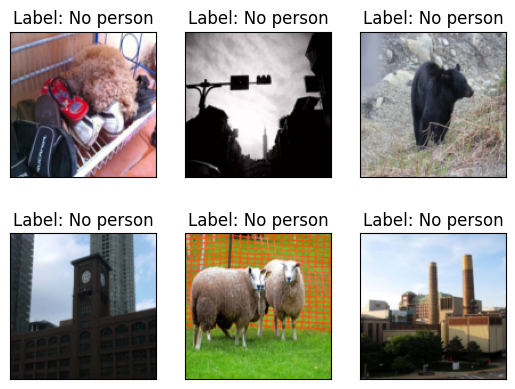

In [5]:
data_dir = "data/vww-s256/val"

val_data_loader = build_val_data_loader(data_dir, resolution=128, batch_size=1)

vis_x, vis_y = 2, 3
fig, axs = plt.subplots(vis_x, vis_y)

num_images = 0
for data, label in val_data_loader:
    img = np.array((((data + 1) / 2) * 255).numpy(), dtype=np.uint8)
    img = img[0].transpose(1, 2, 0)
    if label.item() == 0:
        label_text = "No person"
    else:
        label_text = "Person"
    axs[num_images // vis_y][num_images % vis_y].imshow(img)
    axs[num_images // vis_y][num_images % vis_y].set_title(f"Label: {label_text}")
    axs[num_images // vis_y][num_images % vis_y].set_xticks([])
    axs[num_images // vis_y][num_images % vis_y].set_yticks([])
    num_images += 1
    if num_images > vis_x * vis_y - 1:
        break

plt.show()

여기서 OFA MCUNet의 Design Space가  $>10^{19}$ 나 된다고 하네요. 어마어마하죠? Subnet은 [inverted MobileNet blocks](https://arxiv.org/abs/1801.04381)로 구성돼 있으면서 모델 구조를 바꾸는 파라미터로는 kernel sizes (3, 5, 7), expand ratios (3, 4, 6), depth, global channel scaling (0.5x, 0.75x, 1.0x) (specified by `width_mult_list`) 가 있습니다. 자세한 설명은 이따가 계속할게요.

In [ ]:
device = "cuda:0"
ofa_network = OFAMCUNets(
    n_classes=2,
    bn_param=(0.1, 1e-3),
    dropout_rate=0.0,
    base_stage_width="mcunet384",
    width_mult_list=[0.5, 0.75, 1.0],
    ks_list=[3, 5, 7],
    expand_ratio_list=[3, 4, 6],
    depth_list=[0, 1, 2],
    base_depth=[1, 2, 2, 2, 2],
    fuse_blk1=True,
    se_stages=[False, [False, True, True, True], True, True, True, False],
)

ofa_network.load_state_dict(
    torch.load("vww_supernet.pth", map_location="cpu")["state_dict"], strict=True
)

ofa_network = ofa_network.to(device)

In [ ]:
from mcunet.utils.pytorch_utils import count_peak_activation_size, count_net_flops, count_parameters

def evaluate_sub_network(ofa_network, cfg, image_size=None):
    if "image_size" in cfg:
        image_size = cfg["image_size"]
    batch_size = 128
    # step 1. sample the active subnet with the given config.
    ofa_network.set_active_subnet(**cfg)
    # step 2. extract the subnet with corresponding weights.
    subnet = ofa_network.get_active_subnet().to(device)
    # step 3. calculate the efficiency stats of the subnet.
    peak_memory = count_peak_activation_size(subnet, (1, 3, image_size, image_size))
    macs = count_net_flops(subnet, (1, 3, image_size, image_size))
    params = count_parameters(subnet)
    # step 4. perform BN parameter re-calibration.
    calib_bn(subnet, data_dir, batch_size, image_size)
    # step 5. define the validation dataloader.
    val_loader = build_val_data_loader(data_dir, image_size, batch_size)
    # step 6. validate the accuracy.
    acc = validate(subnet, val_loader)
    return acc, peak_memory, macs, params

We also provide a handly helper function to visualize the architecture of the subnets. The function takes in the configuration of the subnet and returns an image representing the architecture.

In [ ]:
def visualize_subnet(cfg):
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], cfg["image_size"], out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

위 코드를 이용해서 모델구조 시각화도 할텐데요, MBConv3-3x3과 같은 이름이 나올거에요. 각각 expand ratio `e`와  kernel size of the depthwise convolution layer `k`로 MBConv{e}-{k}x{k}가 나타나니 참고하시면 좋을 것 같아요.

### More Explanation to understand OFA-MCUNet


과제를 들어가기 앞서 OFA-MCUNet에 대해서 조금 설명할까해요. 내려가면서 모델 구조에 파라미터들이 나오는 데 각 의미를 알면 이해하기가 더 수월할 겁니다.

모델은 총 first_conv, blocks, feature_mix_layer, classifier 으로 구성해요. block에서도 첫 번째, 마지막 block을 제외한 총 6개의 block에서 kernel size, expand ratio, depth, width multiply를 파라미터로 해서 모델을 키우거나, 줄이죠. 각각의 파라미터를 좀 더 살펴보죠!

#### 1. Kernel size
kernel size는 Convolution에 나오는 그 kernel이 맞습니다. 예제에서는 3x3, 5x5, 7x7로 가질 수 있어요.

#### 2. Width multiply, Depth
OFA MCUNet을 블럭으로 표현하면 아래와 같죠. 그중 초록색으로 칠해진 Block을 보시면, Block으로 들어오는 Input Channel과 Output Channel이 있어요. 바로 그 둘을 얼마나 줄일 것인가, 유지할 것인가가 **Width multiply**입니다.

두 번째로 하나의 Block은 MBConv(MobileNet Conv)로 구성됩니다. 그러면 이 MBConv가 몇 개가 들어 갈 것이냐가 관건일 텐데요, 이걸 정하는 것이 **Depth**입니다. 파라미터에서는 depth_list와 base_depth로 나눠서 각 block별로 base_depth를 기준으로 depth_list에 나오는 개수 만큼 더 MBConv이 추가되죠.

![](images/lab03/diagram-6.png)


마지막은 expand ratio 입니다. 이 파라미터는 MBConv 내에서 있어요, 역시나 그림을 보시죠. MBConv는 MobileNet Convolution, Separable Convolution,

SE-Block, 그리고 다시 MobileNet Convolution으로 구성되요. 그 중, 처음 입력의 채널과 첫 MobileNet Convolution을 거치고 나온 출력 채널의 비를 Expand ratio라고 합니다.

![-](images/lab03/diagram-7.png)

In [1]:
# OFAMCUNets
# constitutes: first_conv, blocks, feature_mix_layer, classifier
# total 9 block (first_conv, first block, blocks, last block)
# 1. first_conv = 1x1 channel inc conv (3 -> X)
# 2. first block = MB InvertedConvLayer

# 3. blocks
# - depth = num block
# - 1 block = MobileInvertedResidualBlock = MBConvLayer + Residual
#############################################################
# Dynamic MBConvLayer = 2 times channel expansion           #
#                  fuse_blk1    se_stage                    #
# MBConvLayer + SeparableConv + SEBlock + MBConvLayer       #
#############################################################
# SEblock: conv 1x1 (reduce) -> act -> conv 1x1 (expand) -> h_sigmoid
# -> SENet(Squeeze-and-Excitation Network)

# 4. Last block = Mobile Inverted Residual Blcok
# 5. feature_mix_layer = 1x1 channel dec conv
# 6. classifier = linear layer

# Parameters (sample_active_subnet)
# kernel size, expand ratio, depth, width multiplY

코드 중 make_divisible이라는 메서드가 있습니다. 여기선 채널을 늘리거나 줄일 때 **8**로 나눌 수 있게 합니다. tensorflow에서도 사용한다고 하는데, 이유는 아직 모르겠네요!

```python
def make_divisible(v, divisor, min_val=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_val:
    :return:
    """
    if min_val is None:
        min_val = divisor
    new_v = max(min_val, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
```

### TL;DR. Summary

실험은 총 4 단계로 나뉩니다. 여기서 파라미터는 kernel size, expand ratio, depth, width multiply죠.

#### 1. OFA-MCUNet
처음은 훈련된 vww_supernet을 가지고 파라미터마다 accuracy 조합을 구합니다. 그리고 각 결과마다 이후에 constraint 범위 내에 들어오는 모델구조를 찾기 위해 MAC과 Peak memory 또한 구할 겁니다.

#### 2. Accuracy Predictor
앞서서 구한 파라미터마다 Accuracy를 가지고, 이번엔 반대로 이 데이터를 가지고 Accuracy를 예측하는 모델을 훈련시킬겁니다. 모델은 Linear Layer가 세층으로 쌓여있는 간단한 모델을 사용하죠. 하지만 파타미터 조합을 Embedding vector로 만들기 위해 encoder가 들어갑니다.

#### 3. Encoding: MCUNetArchEncoder
그 과정에서 파라미터 조합을 Embedding vector로 Encoding을 합니다. 예를 들어, Kenral size가 3x3, 5x5, 7x7 이 있는 경우 각각을 (0, 0, 1), (0, 1, 0), (1, 0, 0) 이렇게 encoding 하는 거죠. 이 encoding이 들어간 Accuracy Predictor 모델을 훈련시킵니다. 훈련시킨 모델의 Prediction과 Label 간의 상관관계가 Linear하게 나오는 것 또한 보여줄 겁니다.

#### 4. Random Search and Evolutionary Search
마지막 단계는 Constraint, 즉 메모리와 MAC에 해당하는 모델의 파라미터를 찾는 단계입니다. Random Mutate 방식과 Crossover 방식을 사용하는데, 자세한 내용은 코드를 참고하시는게 이해하기 더 수월할 겁니다! 참고로 마지막에 Question 10에서 "The activation size of the subnet is at most 64 KB" 의 조건을 가진 모델의 구조는 못찾았습니다. 혹시 찾게 된다면, 혹은 찾지 못하는 이유를 아시게된다면 공유해주세요!

### OFA_network's forward

모델 실험하기에 앞서서, 채널을 만약 줄인다면 어떤식으로 할지 Convolution Network에서 나온 코드를 가져와봤어요. 파라미터에 맞게 결정한 out_channel, in_channel을 아래 코드 처럼 잘라 active subnet이라고 부를 거에요. 실험은 제가 임의로 이미지 사이즈를 48, 96, 128, 256, 384, 512로 키워나가면서 했고, sub network로 샘플링하는 방법으로는 random, max, min으로 했습니다. 

```python
filters = self.conv.weight[:out_channel, :in_channel, :, :].contiguous()
padding = get_same_padding(self.kernel_size)
y = F.conv2d(x, filters, None, self.stride, padding, self.dilation, 1)
```

흥미로웠던 건 이미지가 커지면 커질수록 Accuracy는 계속 올라가다가 512에서 부터 떨어지더라구요. 실험결과는 아래를 참고바랍니다.

Validate: 100%|██████████| 32/32 [00:00<00:00, 51.09it/s, loss=0.603, top1=65.9]


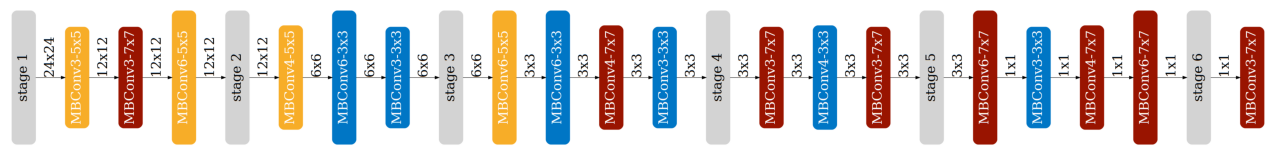

The accuracy of the sampled subnet: #params= 1.6M, accuracy= 65.9%.


Validate: 100%|██████████| 32/32 [00:00<00:00, 53.97it/s, loss=0.625, top1=64.2]


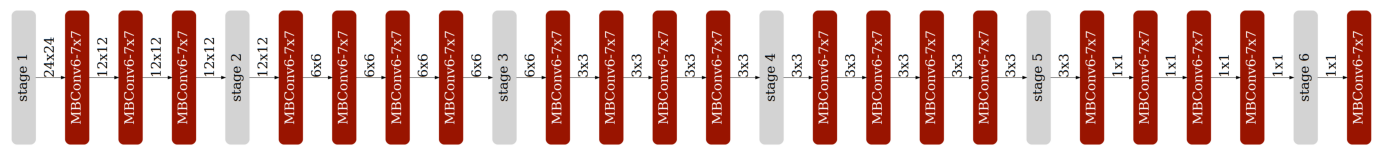

The largest subnet: #params= 2.5M, accuracy= 64.2%.


Validate: 100%|██████████| 32/32 [00:00<00:00, 51.76it/s, loss=0.718, top1=59.3]


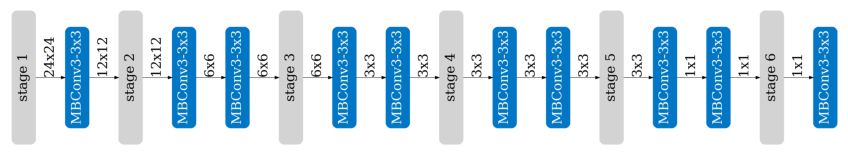

The smallest subnet: #params= 0.3M, accuracy= 59.3%.


In [32]:
# sample_active_subnet
# kernel size, expand ratio, depth, width mult

image_size = 48

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:00<00:00, 35.68it/s, loss=0.321, top1=86.4]

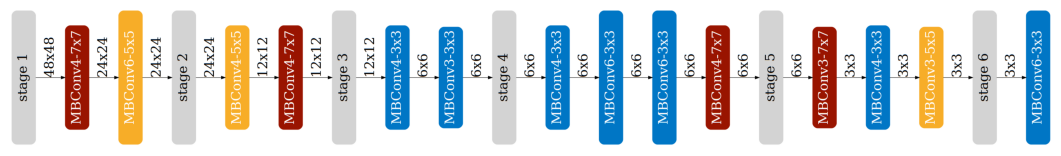

The accuracy of the sampled subnet: #params= 0.6M, accuracy= 86.4%.


Validate: 100%|██████████| 32/32 [00:00<00:00, 42.76it/s, loss=0.29, top1=88.6] 


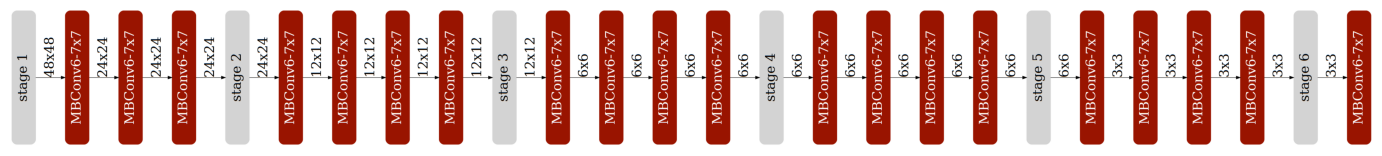

The largest subnet: #params= 2.5M, accuracy= 88.6%.


Validate: 100%|██████████| 32/32 [00:00<00:00, 44.92it/s, loss=0.379, top1=83.4]


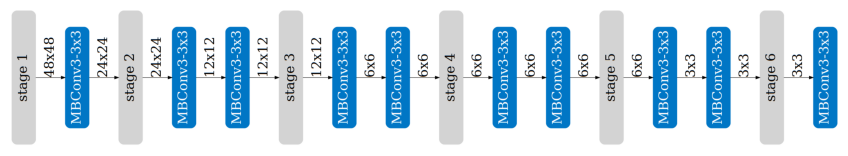

The smallest subnet: #params= 0.3M, accuracy= 83.4%.


In [9]:
image_size = 96

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:00<00:00, 39.53it/s, loss=0.228, top1=91.3]


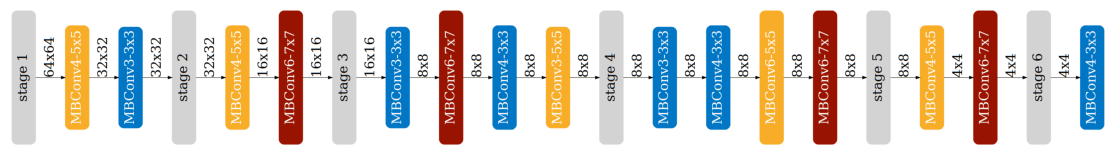

The accuracy of the sampled subnet: #params= 1.3M, accuracy= 91.3%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 30.92it/s, loss=0.21, top1=92.3] 


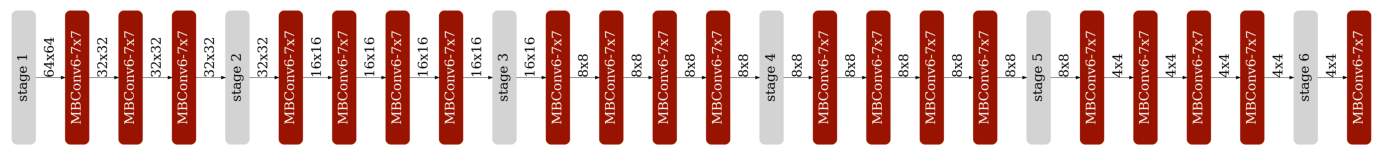

The largest subnet: #params= 2.5M, accuracy= 92.3%.


Validate: 100%|██████████| 32/32 [00:00<00:00, 40.69it/s, loss=0.307, top1=87.3]


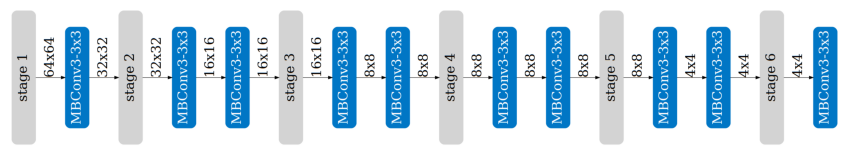

The smallest subnet: #params= 0.3M, accuracy= 87.3%.


In [29]:
image_size = 128

# sample_active_subnet
# kernel size, expand ratio, depth, width mult

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:01<00:00, 19.93it/s, loss=0.187, top1=93.5]


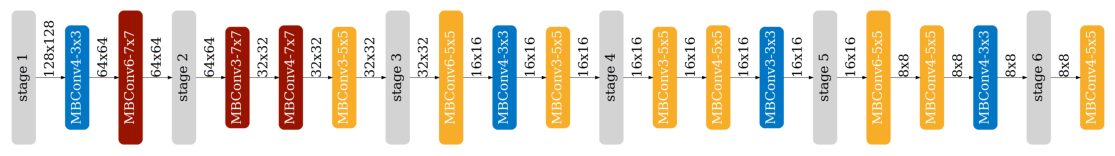

The accuracy of the sampled subnet: #params= 0.6M, accuracy= 93.5%.


Validate: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s, loss=0.177, top1=93.9] 


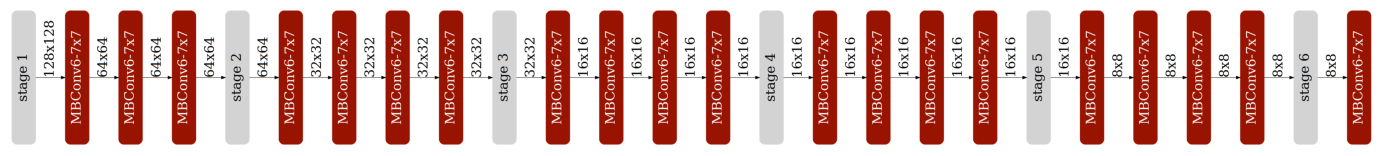

The largest subnet: #params= 2.5M, accuracy= 93.9%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 25.67it/s, loss=0.258, top1=90.2]


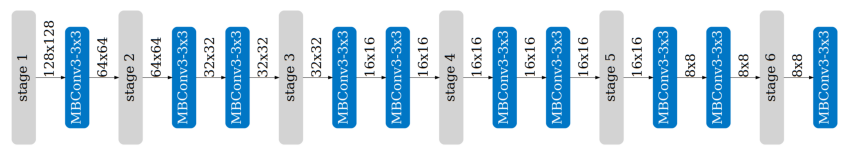

The smallest subnet: #params= 0.3M, accuracy= 90.2%.


In [26]:
image_size = 256

# sample_active_subnet
# kernel size, expand ratio, depth, width mult

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s, loss=0.241, top1=91.1] 


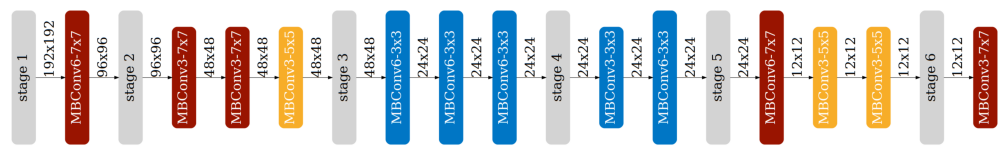

The accuracy of the sampled subnet: #params= 1.1M, accuracy= 91.1%.


Validate: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, loss=0.263, top1=90.5] 


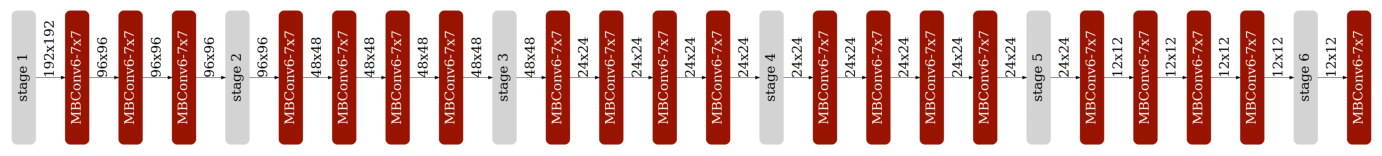

The largest subnet: #params= 2.5M, accuracy= 90.5%.


Validate: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s, loss=0.34, top1=85.4] 


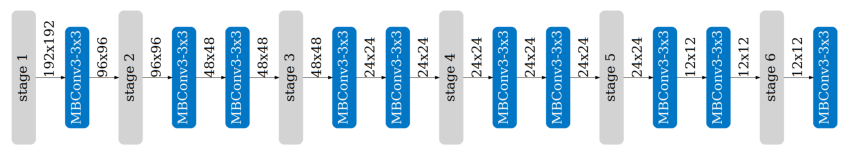

The smallest subnet: #params= 0.3M, accuracy= 85.4%.


In [30]:
image_size = 256+128

# sample_active_subnet
# kernel size, expand ratio, depth, width mult

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, loss=0.376, top1=83.1]


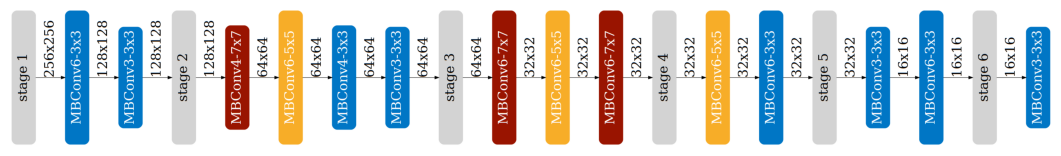

The accuracy of the sampled subnet: #params= 0.5M, accuracy= 83.1%.


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s, loss=0.413, top1=81]   


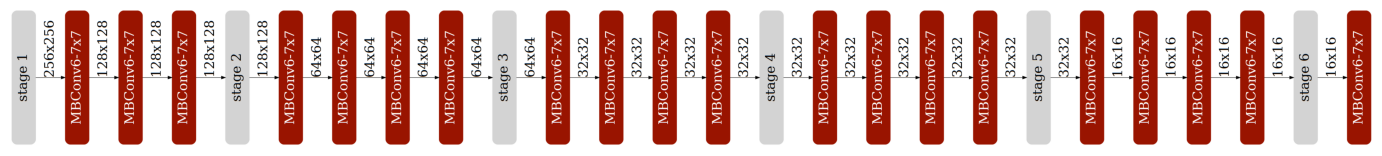

The largest subnet: #params= 2.5M, accuracy= 81.0%.


Validate: 100%|██████████| 32/32 [00:04<00:00,  7.23it/s, loss=0.489, top1=76.1]


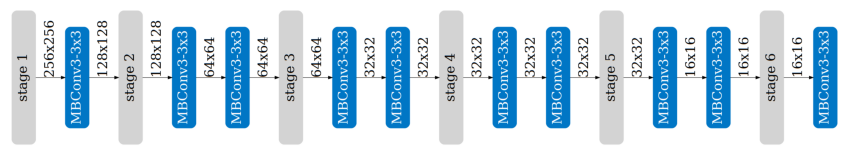

The smallest subnet: #params= 0.3M, accuracy= 76.1%.


In [28]:
image_size = 512

# sample_active_subnet
# kernel size, expand ratio, depth, width mult

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

### Question 1: Design space exploration.

Try manually sample different subnets by running the cell above multiple times. You can also vary the input resolution. Talk about your findings.

Hint: which dimension plays the most important role for the accuracy?

**Answer:** Image resolution plays the most important role for classification accuracy.

네, 질문에서 사실 힌트를 얻어 실험을 했습니다. "Image resolution에 따른 Accuracy 변화"를 알 수 있었습니다.


## Part 1. Predictors

이제 두번째 단계는 앞서서 모델을 통해 얻은 VWW dataset으로 Accuracy를 예측하는 모델을 만들겁니다. 모델은 생각모다 간단해요, Linear 세 층으로 구성돼 있죠. 아래 그램은 궁극적으로 Constraint에 해당하는 모델을 우리는 구할거다, 이런 내용입니다.


![](images/lab03/6.png)

Efficiency predictor는 모델 구조가 결정되면 Accuracy와 함께 나올거에요. 앞선 예제에서 했으니 기억이 안나신다면 이전 예제로!

### Question 2: Implement the efficiency predictor.

처음은 "AnalyticalEfficiencyPredictor"라는 클래스를 만듭니다. 이미지 크기에 따라 MAC과 메모리를 계산해주고(get_efficiency), 이 두가지가 타겟하고 부합하는지도 알려주는 함수(satisfy_constraint)도 만듭니다. FLOP과 메모리 계산은 교수님이 친절하게 만들어 놓으신 count_net_flops과 count_peak_activation_size를 사용하면 됩니다.

In [33]:
class AnalyticalEfficiencyPredictor:
    def __init__(self, net):
        self.net = net

    def get_efficiency(self, spec: dict):
        self.net.set_active_subnet(**spec)
        subnet = self.net.get_active_subnet()
        if torch.cuda.is_available():
            subnet = subnet.cuda()
        ############### YOUR CODE STARTS HERE ###############
        # Hint: take a look at the `evaluate_sub_network` function above.
        # Hint: the data shape is (batch_size, input_channel, image_size, image_size)
        data_shape = (1, 3, spec["image_size"], spec["image_size"])
        macs = count_net_flops(subnet, data_shape)
        peak_memory = count_peak_activation_size(subnet, data_shape)
        ################ YOUR CODE ENDS HERE ################

        return dict(millionMACs=macs / 1e6, KBPeakMemory=peak_memory / 1024)

    def satisfy_constraint(self, measured: dict, target: dict):
        for key in measured:
            # if the constraint is not specified, we just continue
            if key not in target:
                continue
            # if we exceed the constraint, just return false.
            if measured[key] > target[key]:
                return False
        # no constraint violated, return true.
        return True

Let's test your implementation for the analytical efficiency predictor by examining the returned values for the smallest and largest subnets we just evaluated a while ago. The results from the efficiency predictor should match with the previous results.

In [34]:
efficiency_predictor = AnalyticalEfficiencyPredictor(ofa_network)

image_size = 96
# Print out the efficiency of the smallest subnet.
smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
eff_smallest = efficiency_predictor.get_efficiency(smallest_cfg)

# Print out the efficiency of the largest subnet.
largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
eff_largest = efficiency_predictor.get_efficiency(largest_cfg)

print("Efficiency stats of the smallest subnet:", eff_smallest)
print("Efficiency stats of the largest subnet:", eff_largest)

Efficiency stats of the smallest subnet: {'millionMACs': 8.302128, 'KBPeakMemory': 72.0}
Efficiency stats of the largest subnet: {'millionMACs': 79.416432, 'KBPeakMemory': 270.0}


### Question 3: Implement the accuracy predictor.

이제 Accuracy predictor를 만들어야죠? 그전에, 데이터셋으로 주어진 걸 살펴보니 파라미터간 조합으로 보입니다. 이를 데이터로써 쓰기 위해 임베딩을 해야하는데 그 역할을 바로 MCUNetArchEncoder가 합니다. 역시나 교수님이 친절하게 만들어주셨군요. 그리고 Accuracy predictor 모델 구조는 MLP (multi-layer perception)를 사용할겁니다.

The accuracy predictor takes in the architecture of a sub-network and predicts its accuracy on the VWW dataset. Since it is an MLP network, the sub-network must be encoded into a **vector**. In this lab, we provide a class `MCUNetArchEncoder` to perform such conversion from **sub-network architecture** to a **binary vector**. 

In [35]:
image_size_list = [96, 112, 128, 144, 160]
arch_encoder = MCUNetArchEncoder(
    image_size_list=image_size_list,
    base_depth=ofa_network.base_depth,
    depth_list=ofa_network.depth_list,
    expand_list=ofa_network.expand_ratio_list,
    width_mult_list=ofa_network.width_mult_list,
)

We generated an accuracy dataset beforehand, which is a collection of `[architecture, accuracy]` pairs stored under the `acc_datasets` folder.

With the architecture encoder, you are now required define the accuracy predictor, which is a multi-layer perception (MLP) network with 400 channels per intermediate layer. For simplicity, we fix the number of layers to be **3**. Please implement this MLP network in the following cell.

In [13]:
class AccuracyPredictor(nn.Module):
    def __init__(
        self,
        arch_encoder,
        hidden_size=400,
        n_layers=3,
        checkpoint_path=None,
        device="cuda:0",
    ):
        super(AccuracyPredictor, self).__init__()
        self.arch_encoder = arch_encoder
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        layers = []
        
        ############### YOUR CODE STARTS HERE ###############
        # Let's build an MLP with n_layers layers. 
        # Each layer (nn.Linear) has hidden_size channels and 
        # uses nn.ReLU as the activation function.
        # Hint: You can assume that n_layers is fixed to be 3, for simplicity.
        # Hint: the input dimension of the first layer is not hidden_size.
        for i in range(self.n_layers):
            layers.append(
                nn.Sequential(
                    nn.Linear(
                        self.arch_encoder.n_dim if i == 0 else self.hidden_size,
                        self.hidden_size,
                    ),
                    nn.ReLU(inplace=True),
                )
            )
        ################ YOUR CODE ENDS HERE ################
        layers.append(nn.Linear(self.hidden_size, 1, bias=False))
        self.layers = nn.Sequential(*layers)
        self.base_acc = nn.Parameter(
            torch.zeros(1, device=self.device), requires_grad=False
        )

        if checkpoint_path is not None and os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location="cpu")
            if "state_dict" in checkpoint:
                checkpoint = checkpoint["state_dict"]
            self.load_state_dict(checkpoint)
            print("Loaded checkpoint from %s" % checkpoint_path)

        self.layers = self.layers.to(self.device)

    def forward(self, x):
        y = self.layers(x).squeeze()
        return y + self.base_acc

    def predict_acc(self, arch_dict_list):
        X = [self.arch_encoder.arch2feature(arch_dict) for arch_dict in arch_dict_list]
        X = torch.tensor(np.array(X)).float().to(self.device)
        return self.forward(X)

Let's print out the architecture of the `AccuracyPredictor` you just defined.

In [14]:
os.makedirs("pretrained", exist_ok=True)
acc_pred_checkpoint_path = (
    f"pretrained/{ofa_network.__class__.__name__}_acc_predictor.pth"
)
acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    checkpoint_path=None,
    device=device,
)
print(acc_predictor)

AccuracyPredictor(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (3): Linear(in_features=400, out_features=1, bias=False)
  )
)


데이터 셋은 총 4만개의 훈련데이터와 만개의 테스트 데이터로 있고, Accuracy는 모델 파라미터(architecture)와 쌍을 이룰거라는, 내용입니다. 하나 더, 파라미터를 **one-hot representation** 로 바꾸는 과정도 잊지마시죠! 다음 결과를 보시면 "kernel size embedding: [0 1 0] => kernel size: 5; expand ratio embedding: [0 1 0] => expand ratio: 4" 이러면서 모델 구조가 임베딩된 걸 확인하실 수 있어요

Let's first visualize some samples in the accuracy dataset in the following cell.

The accuracy dataset is composed of 50,000 `[architecture, accuracy]` pairs, where 40,000 of them are used as the training set and the rest 10,000 are used as validation set. 

For **accuracy**, We calculate the average accuracy of all `[architecture, accuracy]` pairs on the accuracy dataset and define it as `base_acc`. For the accuracy predictor, instead of directly regressing the accuracy of each architecture, its training target is `accuracy - base_acc`. Since `accuracy - base_acc` is usually much smaller than `accuracy` itself, this can make training easier.

For **architecture**, each subnet within the design space is uniquely represented by a binary vector. The binary vector is a concatenation of the **one-hot representation** for both global parameters (*e.g.* input resolution, width multiplier) and parameters of each inverted MobileNet block (*e.g.* kernel sizes and expand ratios). Note that we prefer **one-hot** representations over **numerical** representations because all design hyperparameters are **discrete** values.

For example, our design space supports 

```python
kernel_size = [3, 5, 7]
expand_ratio = [3, 4, 6]
```

Then, we represent `kernel_size=3` as `[1, 0, 0]`, `kernel_size=5` as `[0, 1, 0]`, and `kernel_size=7` as `[0, 0, 1]`. Similarly, for `expand_ratio=3`, it is written as `[1, 0, 0]`; `expand_ratio=4` is written as `[0, 1, 0]` and `expand_ratio=6` is written as `[0, 0, 1]`. The representation for each inverted MobileNet block is obtained by concatenating the kernel size embedding with the expand ratio embedding. Note that for skipped blocks, we use `[0, 0, 0]` to represent their kernel sizes and expand ratios. You will see a detailed explanation of the architecture-embedding correspondence after running the following cell.

Loading data: 100%|██████████| 50000/50000 [00:00<00:00, 228025.66it/s]


Train Size: 40000, Valid Size: 10000
The basic accuracy (mean accuracy of all subnets within the dataset is:  90.3%.
network embedding: [1 0 0 0 0 | 0 1 0 | 0 1 0 | 0 1 0 | 1 0 0 | 0 0 1 | 1 0 0 | 1 0 0 | 0 0 1 | 1 0 0 | 0 1 0 | 0 1 0 | 0 0 1 | 0 0 1 | 0 0 0 | 0 0 0 | 0 1 0 | 0 0 1 | 0 1 0 | 0 0 1 | 0 1 0 | 0 1 0 | 0 1 0 | 0 0 1 | 1 0 0 | 1 0 0 | 0 1 0 | 0 1 0 | 0 0 1 | 0 0 1 | 0 1 0 | 0 0 1 | 0 0 1 | 1 0 0 | 0 1 0 | 0 0 1 | 0 0 0 | 0 0 0 | 0 0 0 | 0 0 0 | 0 1 0 | 0 0 1]
image resolution embedding: [1 0 0 0 0] => image resolution: 96
width multiplier embedding: [0 1 0] => width multiplier: 0.75
**************************************************Stage1**************************************************
kernel size embedding: [0 1 0] => kernel size: 5; expand ratio embedding: [0 1 0] => expand ratio: 4
kernel size embedding: [1 0 0] => kernel size: 3; expand ratio embedding: [0 0 1] => expand ratio: 6
kernel size embedding: [1 0 0] => kernel size: 3; expand ratio embedding: [1 0 0] => expa

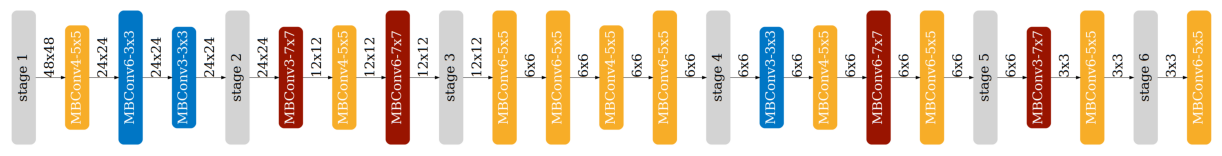

The accuracy of this subnet on the holdout validation set is:  88.7%.


In [15]:
acc_dataset = AccuracyDataset("acc_datasets")
train_loader, valid_loader, base_acc = acc_dataset.build_acc_data_loader(
    arch_encoder=arch_encoder
)

print(f"The basic accuracy (mean accuracy of all subnets within the dataset is: {(base_acc * 100): .1f}%.")

# Let's print one sample in the training set
sampled = 0
for (data, label) in train_loader:
    data = data.to(device)
    label = label.to(device)
    print("=" * 100)
    # dummy pass to print the divided encoding
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=False)
    # print out the architecture encoding process in detail
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=True)
    visualize_subnet(arch_encoding)
    print(f"The accuracy of this subnet on the holdout validation set is: {(label[0] * 100): .1f}%.")
    sampled += 1
    if sampled == 1:
        break


### Question 4: Complete the code for accuracy predictor training.

훈련할 시간입니다!

In [16]:
criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(acc_predictor.parameters())
# the default value is zero
acc_predictor.base_acc.data += base_acc
for epoch in tqdm(range(10)):
    acc_predictor.train()
    for (data, label) in tqdm(train_loader, desc="Epoch%d" % (epoch + 1), position=0, leave=True):
        # step 1. Move the data and labels to device (cuda:0).
        data = data.to(device)
        label = label.to(device)
        ############### YOUR CODE STARTS HERE ###############
        # step 2. Run forward pass.
        pred = acc_predictor(data)
        # step 3. Calculate the loss.
        loss = criterion(pred, label)
        # step 4. Perform the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ################ YOUR CODE ENDS HERE ################

    acc_predictor.eval()
    with torch.no_grad():
        with tqdm(total=len(valid_loader), desc="Val", position=0, leave=True) as t:
            for (data, label) in valid_loader:
                # step 1. Move the data and labels to device (cuda:0).
                data = data.to(device)
                label = label.to(device)
                ############### YOUR CODE STARTS HERE ###############
                # step 2. Run forward pass.
                pred = acc_predictor(data)
                # step 3. Calculate the loss.
                loss = criterion(pred, label)
                ############### YOUR CODE ENDS HERE ###############
                t.set_postfix({"loss": loss.item()})
                t.update(1)

if not os.path.exists(acc_pred_checkpoint_path):
    torch.save(acc_predictor.cpu().state_dict(), acc_pred_checkpoint_path)

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


훈련한 모델의 Prediction과 실제 수치와 Corrleation이 그래프로 보이네요. "Linear" 합니다.

Val:   0%|          | 0/40 [00:00<?, ?it/s]

0.8604847192764282 0.9356203079223633


Text(0.5, 1.0, 'Correlation between predicted accuracy and real accuracy')

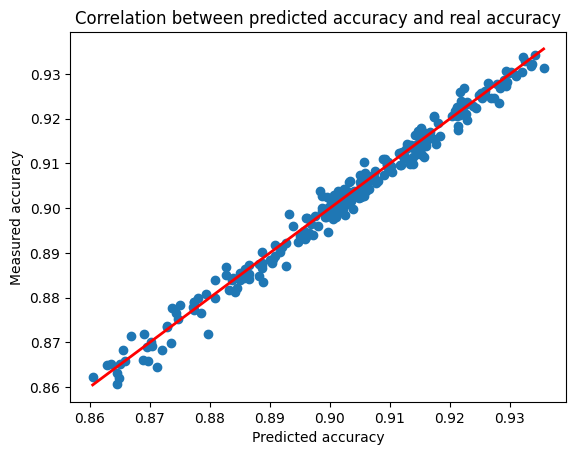

In [39]:
predicted_accuracies = []
ground_truth_accuracies = []
acc_predictor = acc_predictor.to("cuda:0")
acc_predictor.eval()
with torch.no_grad():
    with tqdm(total=len(valid_loader), desc="Val") as t:
        for (data, label) in valid_loader:
            data = data.to(device)
            label = label.to(device)
            pred = acc_predictor(data)
            predicted_accuracies += pred.cpu().numpy().tolist()
            ground_truth_accuracies += label.cpu().numpy().tolist()
            if len(predicted_accuracies) > 200:
                break
plt.scatter(predicted_accuracies, ground_truth_accuracies)
# draw y = x
min_acc, max_acc = min(predicted_accuracies), max(predicted_accuracies)
print(min_acc, max_acc)
plt.plot([min_acc, max_acc], [min_acc, max_acc], c="red", linewidth=2)
plt.xlabel("Predicted accuracy")
plt.ylabel("Measured accuracy")
plt.title("Correlation between predicted accuracy and real accuracy")

## Part 2. Neural Architecture Search

드디어 마지막 단계입니다. 원하는 모델을 찾아보죠! 두 가지 Search 방법을 이용할 건데, 하나는 Random Search이고, 다른 하나는 evolutionary Search 이용한 Neural Architecture Search입니다(드디어 NAS!).

![](images/lab03/7.png)

### Question 5: Complete the following random search agent.

Random Search는 열심히 constraint에 해당하는 Sample을 모아서 최고의 Accuracy를 가진 모델 구조를 고르면 됩니다.

In [40]:
class RandomSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint 
        while True:
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def run_search(self, constraint, n_subnets=100):
        subnet_pool = []
        # sample subnets
        for _ in tqdm(range(n_subnets)):
            sample, efficiency = self.random_valid_sample(constraint)
            subnet_pool.append(sample)
        # predict the accuracy of subnets
        accs = self.accuracy_predictor.predict_acc(subnet_pool)
        ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        # get the index of the best subnet
        best_idx = accs.argmax()
        ############### YOUR CODE ENDS HERE #################
        # return the best subnet
        return accs[best_idx], subnet_pool[best_idx]

### Question 6: Complete the following function.

Note: MACs 100M results lower than MACs 50M, Prof. Han says this might not be intuitive.

In [43]:
def search_and_measure_acc(agent, constraint, **kwargs):
    ############### YOUR CODE STARTS HERE ###############
    # hint: call the search function
    best_info = agent.run_search(constraint=constraint, **kwargs)
    ############### YOUR CODE ENDS HERE #################
    # get searched subnet
    
    print("Best info: ", best_info)

    ofa_network.set_active_subnet(**best_info[1])
    subnet = ofa_network.get_active_subnet().to(device)
    # calibrate bn
    calib_bn(subnet, data_dir, 128, best_info[1]["image_size"])  # ?
    # build val loader
    val_loader = build_val_data_loader(data_dir, best_info[1]["image_size"], 128)
    # measure accuracy
    acc = validate(subnet, val_loader)
    # print best_info
    print(f"Accuracy of the selected subnet: {acc}")
    # visualize model architecture
    visualize_subnet(best_info[1])
    return acc, subnet


Random search with constraint: MACs <= 50M


100%|██████████| 300/300 [00:19<00:00, 15.43it/s]

Best info:  (tensor(0.9327, device='cuda:0', grad_fn=<SelectBackward0>), {'ks': [5, 7, 5, 3, 3, 7, 5, 3, 7, 3, 3, 3, 7, 5, 5, 5, 7, 5, 3, 7], 'e': [4, 3, 3, 6, 4, 3, 6, 6, 4, 3, 3, 4, 4, 6, 6, 4, 3, 4, 4, 3], 'd': [2, 2, 1, 1, 2, 0], 'image_size': 160, 'wid': 1})



Validate: 100%|██████████| 32/32 [00:01<00:00, 30.42it/s, loss=0.187, top1=93.3]


Accuracy of the selected subnet: 93.27543427346657


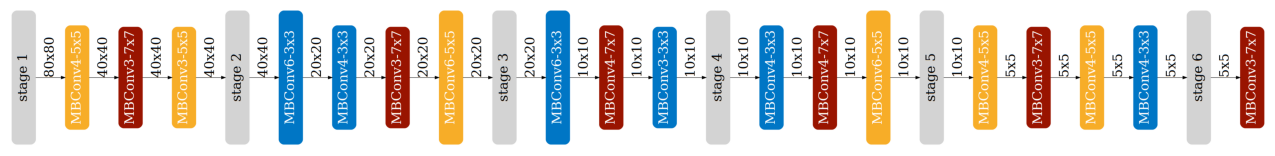

Random search with constraint: MACs <= 100M


100%|██████████| 300/300 [00:19<00:00, 15.05it/s]

Best info:  (tensor(0.9329, device='cuda:0', grad_fn=<SelectBackward0>), {'ks': [3, 3, 5, 7, 7, 5, 5, 7, 7, 3, 5, 5, 5, 3, 7, 5, 7, 5, 5, 3], 'e': [4, 3, 6, 3, 3, 6, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 6, 6, 3], 'd': [2, 2, 1, 1, 2, 2], 'image_size': 160, 'wid': 1})



Validate: 100%|██████████| 32/32 [00:01<00:00, 30.58it/s, loss=0.186, top1=93.5]


Accuracy of the selected subnet: 93.47394543971969


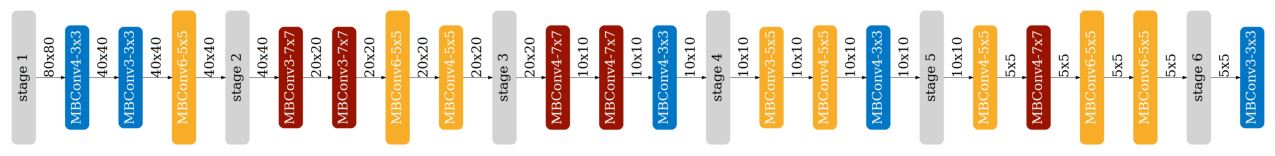

Random search with constraint: Peak memory <= 256KB


100%|██████████| 300/300 [00:43<00:00,  6.83it/s]

Best info:  (tensor(0.9248, device='cuda:0', grad_fn=<SelectBackward0>), {'ks': [7, 7, 5, 7, 7, 5, 3, 5, 3, 5, 3, 5, 7, 3, 3, 5, 7, 7, 5, 3], 'e': [4, 4, 6, 4, 6, 3, 6, 4, 6, 6, 6, 4, 4, 4, 4, 6, 3, 6, 4, 4], 'd': [1, 1, 1, 1, 1, 1], 'image_size': 160, 'wid': 0})



Validate: 100%|██████████| 32/32 [00:00<00:00, 34.29it/s, loss=0.204, top1=92.8]


Accuracy of the selected subnet: 92.8287840963889


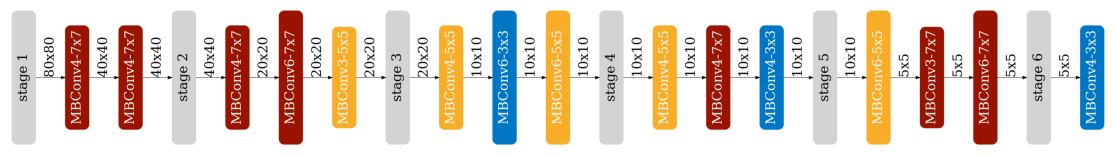

Random search with constraint: Peak memory <= 512KB


100%|██████████| 300/300 [00:22<00:00, 13.54it/s]

Best info:  (tensor(0.9328, device='cuda:0', grad_fn=<SelectBackward0>), {'ks': [3, 3, 3, 3, 5, 5, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 7, 7, 3, 3], 'e': [4, 3, 6, 4, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 3, 6, 4, 4, 3, 6], 'd': [2, 1, 2, 0, 2, 0], 'image_size': 160, 'wid': 1})



Validate: 100%|██████████| 32/32 [00:01<00:00, 29.29it/s, loss=0.19, top1=93.2] 


Accuracy of the selected subnet: 93.15136479455839


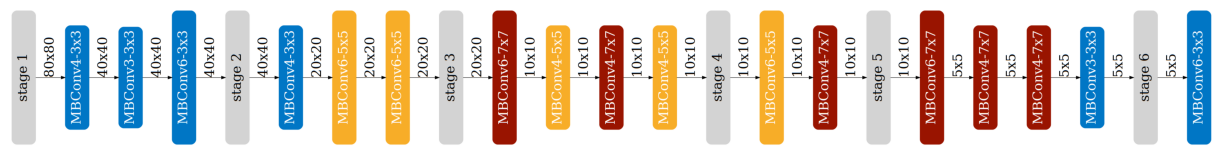

In [44]:
random.seed(1)
np.random.seed(1)
nas_agent = RandomSearcher(efficiency_predictor, acc_predictor)
# MACs-constrained search
subnets_rs_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millonMACs=millonMACs)
    print(f"Random search with constraint: MACs <= {millonMACs}M")
    subnets_rs_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)

# memory-constrained search
subnets_rs_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Random search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_rs_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)


### Question 7: Complete the following evolutionary search agent.

Evolutionary Search는 여기서 한 단계가 더 들어가요. 바로 "Crossover"이라는 단계인데, 랜덤으로 뽑은 두 샘플에서 또 다시 모델 구조에서 부분을 나눠 랜덤으로 둘 중에 하나를 뽑아서 합치는 과정입니다. sub-network가 뽑히는 개수를 population이라고 하면서 랜덤 샘플링을 하는 횟수를 generation, 그리고 max_time_budget을 둬서 몇번의 generation을 거칠 것인가도 제한합니다. 매 generation마다 모이는 population을 정렬할 거거든요.

In [21]:
class EvolutionSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor, **kwargs):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

        # evolution hyper-parameters
        self.arch_mutate_prob = kwargs.get("arch_mutate_prob", 0.1)
        self.resolution_mutate_prob = kwargs.get("resolution_mutate_prob", 0.5)
        self.population_size = kwargs.get("population_size", 100)
        self.max_time_budget = kwargs.get("max_time_budget", 500)
        self.parent_ratio = kwargs.get("parent_ratio", 0.25)
        self.mutation_ratio = kwargs.get("mutation_ratio", 0.5)

    def update_hyper_params(self, new_param_dict):
        self.__dict__.update(new_param_dict)

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint 
        while True:
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def mutate_sample(self, sample, constraint):
        while True:
            new_sample = copy.deepcopy(sample)

            self.accuracy_predictor.arch_encoder.mutate_resolution(new_sample, self.resolution_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_width(new_sample, self.arch_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_arch(new_sample, self.arch_mutate_prob)

            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def crossover_sample(self, sample1, sample2, constraint):
        while True:
            new_sample = copy.deepcopy(sample1)
            for key in new_sample.keys():
                if not isinstance(new_sample[key], list):
                    ############### YOUR CODE STARTS HERE ###############
                    # hint: randomly choose the value from sample1[key] and sample2[key], random.choice
                    new_sample[key] = random.choice([sample1[key], sample2[key]])
                    ############### YOUR CODE ENDS HERE #################
                else:
                    for i in range(len(new_sample[key])):
                        ############### YOUR CODE STARTS HERE ###############
                        new_sample[key][i] = random.choice([sample1[key][i], sample2[key][i]])
                        ############### YOUR CODE ENDS HERE #################

            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def run_search(self, constraint, **kwargs):
        self.update_hyper_params(kwargs)

        mutation_numbers = int(round(self.mutation_ratio * self.population_size))
        parents_size = int(round(self.parent_ratio * self.population_size))

        best_valids = [-100]
        population = []  # (acc, sample) tuples
        child_pool = []
        best_info = None
        # generate random population
        for _ in range(self.population_size):
            sample, efficiency = self.random_valid_sample(constraint)
            child_pool.append(sample)

        accs = self.accuracy_predictor.predict_acc(child_pool)
        for i in range(self.population_size):
            population.append((accs[i].item(), child_pool[i]))

        # evolving the population
        with tqdm(total=self.max_time_budget) as t:
            for i in range(self.max_time_budget):
                ############### YOUR CODE STARTS HERE ###############
                # hint: sort the population according to the acc (descending order)
                population = sorted(population, key=lambda x: x[0], reverse=True)
                ############### YOUR CODE ENDS HERE #################

                ############### YOUR CODE STARTS HERE ###############
                # hint: keep topK samples in the population, K = parents_size
                # the others are discarded.
                population = population[:parents_size]
                ############### YOUR CODE ENDS HERE #################

                # update best info
                acc = population[0][0]
                if acc > best_valids[-1]:
                    best_valids.append(acc)
                    best_info = population[0]
                else:
                    best_valids.append(best_valids[-1])

                child_pool = []
                for j in range(mutation_numbers):
                    # randomly choose a sample
                    par_sample = population[np.random.randint(parents_size)][1]
                    # mutate this sample
                    new_sample, efficiency = self.mutate_sample(par_sample, constraint)
                    child_pool.append(new_sample)

                for j in range(self.population_size - mutation_numbers):
                    # randomly choose two samples
                    par_sample1 = population[np.random.randint(parents_size)][1]
                    par_sample2 = population[np.random.randint(parents_size)][1]
                    # crossover
                    new_sample, efficiency = self.crossover_sample(
                        par_sample1, par_sample2, constraint
                    )
                    child_pool.append(new_sample)
                # predict accuracy with the accuracy predictor
                accs = self.accuracy_predictor.predict_acc(child_pool)
                for j in range(self.population_size):
                    population.append((accs[j].item(), child_pool[j]))

                t.update(1)

        return best_info

### Question 8: Run evolutionary search and tune evo_params to optimize the results. Describe your findings.

남은 부분은 실험, 실험, 실험입니다. 관찰해보시죠!

Answer:
- The default population size and time budget are too small. Increasing them can effectively improves the final results. But it also increases the search cost. 
- Increasing the probability of resolution mutation can improve the final results. (hint: Question 1)

Evolutionary search with constraint: MACs <= 50M


Validate: 100%|██████████| 32/32 [00:00<00:00, 35.68it/s, loss=0.214, top1=92.3]


Accuracy of the selected subnet: 92.28287844220107


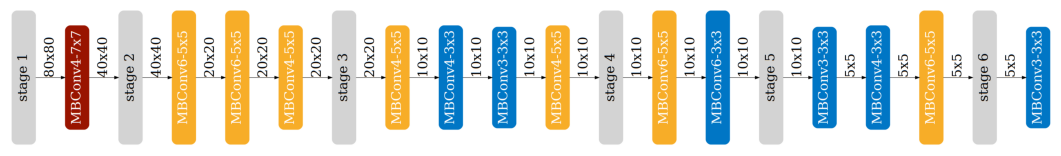

Evolutionary search with constraint: MACs <= 100M


Validate: 100%|██████████| 32/32 [00:00<00:00, 36.25it/s, loss=0.206, top1=92.3]


Accuracy of the selected subnet: 92.33250616939725


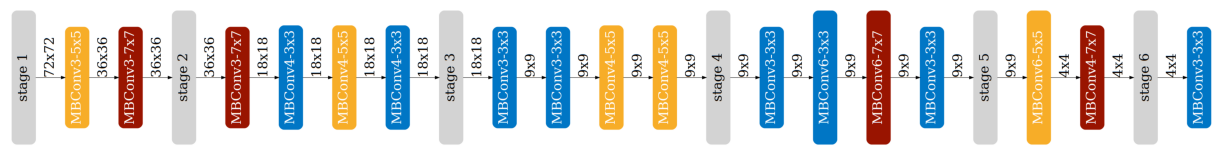

Evolutionary search with constraint: Peak memory <= 256KB


Validate: 100%|██████████| 32/32 [00:00<00:00, 35.39it/s, loss=0.21, top1=92.5] 


Accuracy of the selected subnet: 92.45657571267253


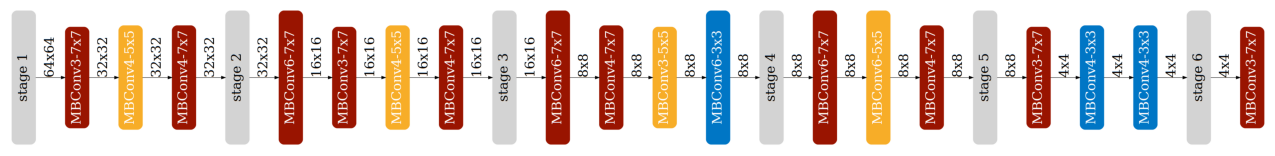

Evolutionary search with constraint: Peak memory <= 512KB


Validate: 100%|██████████| 32/32 [00:00<00:00, 32.62it/s, loss=0.193, top1=93.1]


Accuracy of the selected subnet: 93.05210921143184


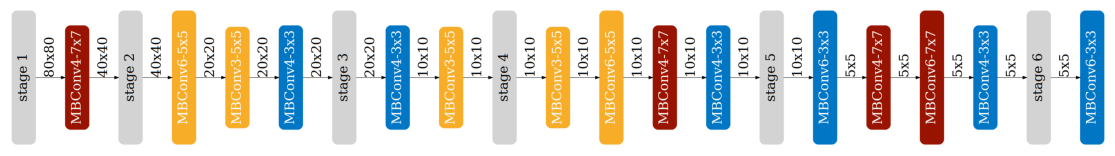

In [22]:
random.seed(1)
np.random.seed(1)

evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,  
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)
# MACs-constrained search
subnets_evo_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millionMACs=millonMACs)
    print(f"Evolutionary search with constraint: MACs <= {millonMACs}M")
    subnets_evo_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint)

# memory-constrained search
subnets_evo_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Evolutionary search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_evo_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint)


### Question 9: Run evolutionary search under real-world constraints.

In real-world applications, we may have multiple efficiency constraints: https://blog.tensorflow.org/2019/10/visual-wake-words-with-tensorflow-lite_30.html. 
Use evolutionary search to find models that satisfy the following constraints:
- [15 pts] 250 KB, 60M MACs (acc >= 92.5% to get the full credit)
- [10 pts, **bonus**] 200KB, 30M MACs (acc >= 90% to get the full credit)

Hint: You do not have to use the same `evo_params` for these two tasks.

Evolution search with constraint: MACs <= 60M, peak memory <= 250KB


Validate: 100%|██████████| 32/32 [00:00<00:00, 36.77it/s, loss=0.201, top1=92.6]


Accuracy of the selected subnet: 92.60545903435415


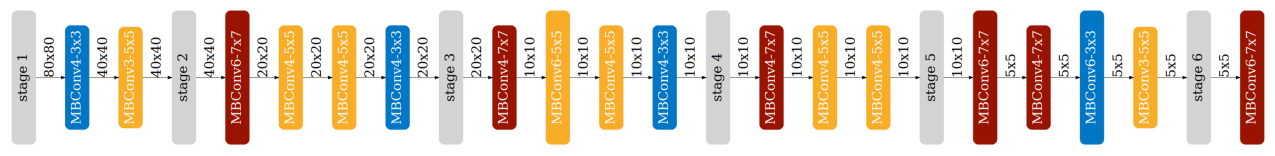

Evolution search finished!


In [23]:
random.seed(1)
np.random.seed(1)
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.5, # The probability of resolution mutation in evolutionary search
    'population_size': 50,  # The size of the population
    'max_time_budget': 20,  
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [60, 250]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

Evolution search with constraint: MACs <= 30M, peak memory <= 200KB


Validate: 100%|██████████| 32/32 [00:00<00:00, 37.25it/s, loss=0.241, top1=90.5]


Accuracy of the selected subnet: 90.54590573748644


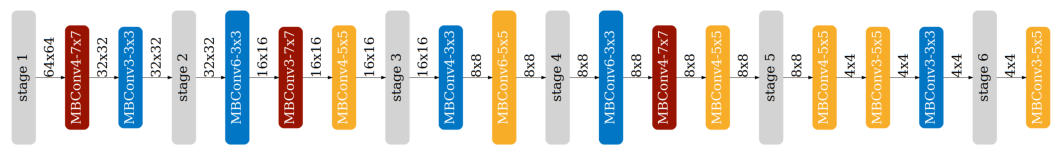

Evolution search finished!


In [24]:
random.seed(1)
np.random.seed(1)
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.5, # The probability of resolution mutation in evolutionary search
    'population_size': 50,  # The size of the population
    'max_time_budget': 30,  
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}
nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [30, 200]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

Evolution search with constraint: MACs <= 15M, peak memory <= 256KB


100%|██████████| 20/20 [01:29<00:00,  4.48s/it]

Best info:  (0.8773346543312073, {'ks': [7, 5, 5, 3, 5, 3, 5, 7, 5, 5, 7, 5, 3, 7, 3, 5, 3, 3, 7, 5], 'e': [4, 6, 6, 6, 4, 3, 3, 4, 3, 4, 4, 6, 6, 4, 6, 4, 3, 4, 3, 3], 'd': [0, 1, 0, 1, 1, 1], 'image_size': 96, 'wid': 0})



Validate: 100%|██████████| 32/32 [00:00<00:00, 45.67it/s, loss=0.319, top1=86.4]


Accuracy of the selected subnet: 86.35235731631296


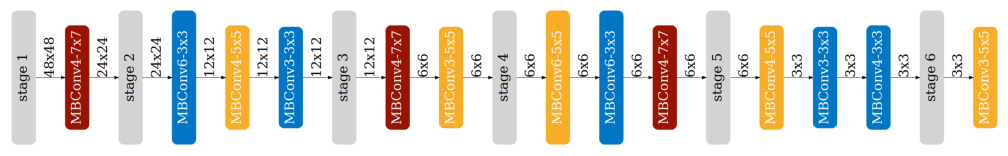

Evolution search finished!


In [45]:
random.seed(1)
np.random.seed(1)
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.5, # The probability of resolution mutation in evolutionary search
    'population_size': 50,  # The size of the population
    'max_time_budget': 20,  
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [15, 256]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

In [46]:
random.seed(1)
np.random.seed(1)
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.5, # The probability of resolution mutation in evolutionary search
    'population_size': 50,  # The size of the population
    'max_time_budget': 20,  
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [60, 64]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

Evolution search with constraint: MACs <= 60M, peak memory <= 64KB


KeyboardInterrupt: 

In [47]:
random.seed(1)
np.random.seed(1)
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.5, # The probability of resolution mutation in evolutionary search
    'population_size': 50,  # The size of the population
    'max_time_budget': 20,  
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [10, 64]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

Evolution search with constraint: MACs <= 10M, peak memory <= 64KB


### Question 10: Is it possible to find a subnet with the following efficiency constraints in the current design space?
- A: The activation size of the subnet is **at most 256KB** and the MACs of the subnet is **at most 15M**.
- B: The activation size of the subnet is **at most 64 KB**.

Answer: 

- A: yes

- B: no